## Lab 03 Question 2: Hyperparameter Tuning
- From a computing engineering viewpoint, improve the neural network by only basing it on under/overfitting and accuracy/loss. Develop the best model possible. No regularization techniques are permitted


### Task: Import and Read Data

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn import*
from tensorflow import keras

# sklearn encoding, data preparation and evaluation tools
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

# Keras (2.X on - I used 2.7 but the below should work for any version.)
from tensorflow import keras
from tensorflow.keras.layers import Dense, SpatialDropout3D
from tensorflow.keras.models import Sequential

# For facets
from IPython.core.display import display, HTML
import base64
!pip install facets-overview==1.0.0
from facets_overview.feature_statistics_generator import FeatureStatisticsGenerator


seed = 1
# fix random seed for reproducibility
np.random.seed(seed)

# Some matplotlib figure sizes
plt.rcParams["figure.figsize"] = (12,8)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [15]:
# Opening the file from github
data_o = pd.read_csv("adult.csv")

### Task: Data Pre-processing

In [16]:
# Used to label encode categorical values
labelencoder = LabelEncoder()

# Converting missing data to NaN
data_o.replace('?', np.nan, inplace=True)

# here we are dropping the NaN values, this is not ideal, and you will be asked questions on this later
data_o.dropna(inplace=True)

data = data_o.copy()
# This code identifies columns that need label encoding, and are then formatted if they do
print("\n\nColumn Names & formatting:\n")
for col in data_o.columns.values.tolist():
    if data_o[col].dtype == "object" or data_o[col].dtype == "bool":
        print("{:<30}".format(col), ":", "{:<30}".format(str(data[col].dtype)) , "Formatting to LabelEncoding")
        data[col] = labelencoder.fit_transform(data[col])
    else:
        print("{:<30}".format(col), ":", "{:<30}".format(str(data[col].dtype)) , "No formatting required.")


# Convert to array
array = data.values


# get seperated input and classifies, using a deep copy of a list, this is for ML models
X = array[:,0:14]
Y = array[:,14]



Column Names & formatting:

age                            : int64                          No formatting required.
workclass                      : object                         Formatting to LabelEncoding
fnlwgt                         : int64                          No formatting required.
education                      : object                         Formatting to LabelEncoding
education.num                  : int64                          No formatting required.
marital.status                 : object                         Formatting to LabelEncoding
occupation                     : object                         Formatting to LabelEncoding
relationship                   : object                         Formatting to LabelEncoding
race                           : object                         Formatting to LabelEncoding
sex                            : object                         Formatting to LabelEncoding
capital.gain                   : int64                        

### Task: Data Preparation

In [17]:
# We are using stratification here, this startifies based on class values. 
X_train, X_test, Y_train, Y_test  = train_test_split(X, Y, test_size=0.33, random_state=seed, shuffle = True, stratify=(Y))


# Examine the class breakdown per dataset:
print("Training dataset length:", len(X_train))
print("Testing dataset length:", len(X_test))

class1TrainingPer = np.count_nonzero(Y_train == 1) / len(X_train)
class1TestPer = np.count_nonzero(Y_test == 1) / len(X_test)

print("\nPercentage of 1's in Training data: ", round(class1TrainingPer*100,2), "%")
print("Percentage of 1's in Test data    : ", round(class1TestPer*100,2), "%")

Training dataset length: 20208
Testing dataset length: 9954

Percentage of 1's in Training data:  24.89 %
Percentage of 1's in Test data    :  24.89 %


### Task: Algorithm Development

In [23]:
# definition to provide plot and accuracy
def plot_acc_loss(results):
  plt.subplot(1,2,1)
  # summarize history for loss
  plt.plot(results.history['loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')

  plt.subplot(1,2,2)
  plt.plot(results.history['acc'])
  plt.title('model accuracy')
  plt.ylabel('acc')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

In [19]:
# definition to provide the metrics
def subMetrics(targetGroup, act, pred):
  print("Metrics for: ", targetGroup)
  print("Total instances in the test set:", len(pred))  
  correct = 0
  # parse both lists to numpy arrays"
  act = np.array(act)
  pred = np.array(pred)
  # There may be an easier way to do this, however, I believe it is a manual process!
  for index, item in enumerate(act):  
    if item == pred[index]:
      correct += 1
  # print accuracy, and the confusion matrix
  accuracy = round((correct / len(act)) * 100,2) 
  print("Accuracy:", accuracy, "%")
  print(pd.crosstab( np.array(act),  np.array(pred), rownames=['Actual'], colnames=['Predicted'], margins=True))
  print("\n")

#### Normal

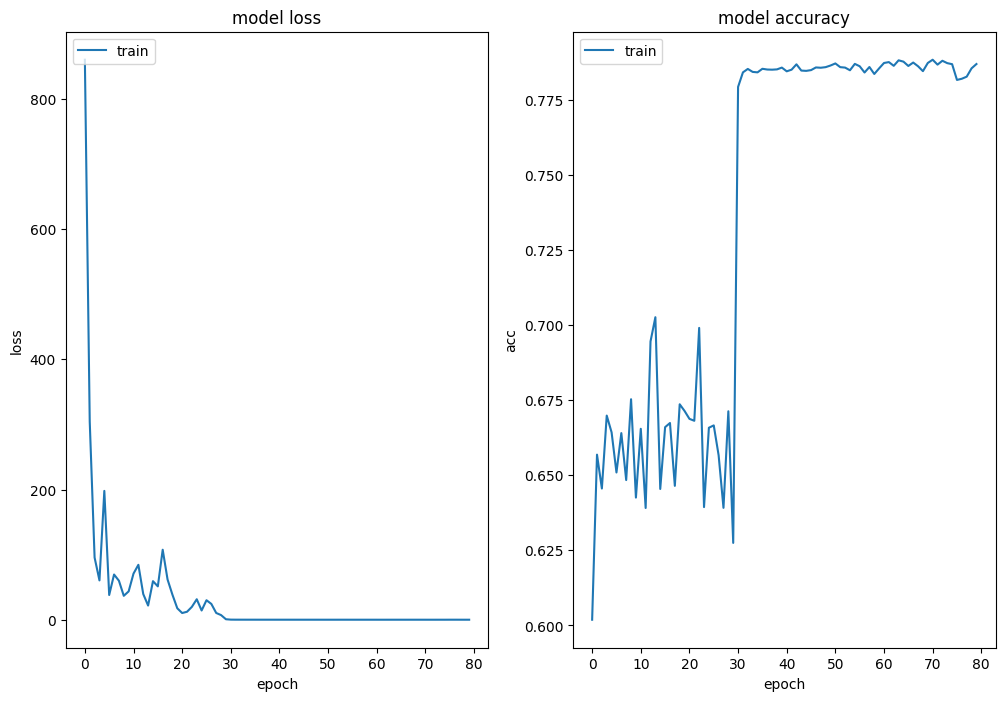

312/312 [==============================] - 1s 3ms/step - loss: 0.5148 - acc: 0.7879
Acuracy:  0.7879244685173035
Predicted     0    1   All
Actual                    
0          7373  103  7476
1          2008  470  2478
All        9381  573  9954


In [26]:
# Need to rerun seed for each DL cell
tf.random.set_seed(seed)

# Building the neural network
modeldl = Sequential()

modeldl.add(Dense(1000, input_dim=14, activation='relu'))
modeldl.add(Dense(100, activation='relu'))
modeldl.add(Dense(100, activation='relu'))
modeldl.add(Dense(50, activation='relu'))
modeldl.add(Dense(1, activation='sigmoid'))

# Compile model - do not change the loss function of metrics, you can change the optimiser if you wish!
modeldl.compile(loss='binary_crossentropy', optimizer="adam", metrics=['acc'])

# Fit the model, change verbose to 2 to see the training cycles.
# Feel free here to modify the batch size and epochs!
results = modeldl.fit(X_train, Y_train, epochs=80, batch_size=1000, verbose=0)

plot_acc_loss(results)

# generate predictions from text data
dl_y_pred = (modeldl.predict(X_test) > 0.5).astype("int32")
dl_y_pred = dl_y_pred.flatten()

print("Acuracy: ", modeldl.evaluate(X_test,Y_test)[1])
print(pd.crosstab(Y_test, dl_y_pred, rownames=['Actual'], colnames=['Predicted'], margins=True))

##### Task: Target Group Bias

In [27]:
# Example for sex target groups  
female_pred = []      # Female was label encoded as 0
female_actual_class = []

male_pred = []        # Male was label encoded as 1
male_actual_class = []


# Populate the confusion matrix grouping by gender (col index 9) you could also do this via group by but would need to convert back to pandas dataframe.
# When grouping by multi class, you will have to modify the below code to include multi class, as for this example there is only two. 
# Also we are using the DT algorithm here, you can change this to DL if you selected that algorithm. 
for index,row in enumerate(X_test):
    if row[9] == 0:       # Female
        female_pred.append(dl_y_pred[index])
        female_actual_class.append(Y_test[index])
    elif row[9] == 1:     # Male
        male_pred.append(dl_y_pred[index])
        male_actual_class.append(Y_test[index])

# Confusion Matrix:
# overall TP, FP, TN, FN values, for binary values only
subMetrics("Female", female_actual_class, female_pred)
subMetrics("Male", male_actual_class, male_pred)

Metrics for:  Female
Total instances in the test set: 3244
Accuracy: 89.43 %
Predicted     0    1   All
Actual                    
0          2830   35  2865
1           308   71   379
All        3138  106  3244


Metrics for:  Male
Total instances in the test set: 6710
Accuracy: 73.65 %
Predicted     0    1   All
Actual                    
0          4543   68  4611
1          1700  399  2099
All        6243  467  6710




In [28]:
# Example for sex target groups  
white_pred = []      
white_actual_class = []
black_pred = []       
black_actual_class = []
asian_pred = []       
asian_actual_class = []
indian_pred = []       
indian_actual_class = []
other_pred = []       
other_actual_class = []

# Populate the confusion matrix grouping by gender (col index 9) you could also do this via group by but would need to convert back to pandas dataframe.
# When grouping by multi class, you will have to modify the below code to include multi class, as for this example there is only two. 
# Also we are using the DT algorithm here, you can change this to DL if you selected that algorithm. 
for index,row in enumerate(X_test):
    if row[8] == 4:       # Female
        white_pred.append(dl_y_pred[index])
        white_actual_class.append(Y_test[index])
    elif row[8] == 2:     # Male
        black_pred.append(dl_y_pred[index])
        black_actual_class.append(Y_test[index])
    elif row[8] == 1:     # Male
        asian_pred.append(dl_y_pred[index])
        asian_actual_class.append(Y_test[index])
    elif row[8] == 0:     # Male
        indian_pred.append(dl_y_pred[index])
        indian_actual_class.append(Y_test[index])
    elif row[8] == 3:     # Male
        other_pred.append(dl_y_pred[index])
        other_actual_class.append(Y_test[index])

# Confusion Matrix:
subMetrics("White", white_actual_class, white_pred)
subMetrics("Black", black_actual_class, black_pred)
subMetrics("Asian", asian_actual_class, asian_pred)
subMetrics("Indian", indian_actual_class, indian_pred)
subMetrics("Other", other_actual_class, other_pred)

Metrics for:  White
Total instances in the test set: 8604
Accuracy: 77.63 %
Predicted     0    1   All
Actual                    
0          6254   94  6348
1          1831  425  2256
All        8085  519  8604


Metrics for:  Black
Total instances in the test set: 885
Accuracy: 89.38 %
Predicted    0   1  All
Actual                 
0          769   5  774
1           89  22  111
All        858  27  885


Metrics for:  Asian
Total instances in the test set: 302
Accuracy: 75.17 %
Predicted    0   1  All
Actual                 
0          209   1  210
1           74  18   92
All        283  19  302


Metrics for:  Indian
Total instances in the test set: 88
Accuracy: 88.64 %
Predicted   0  1  All
Actual               
0          75  2   77
1           8  3   11
All        83  5   88


Metrics for:  Other
Total instances in the test set: 75
Accuracy: 90.67 %
Predicted   0  1  All
Actual               
0          66  1   67
1           6  2    8
All        72  3   75




#### Small

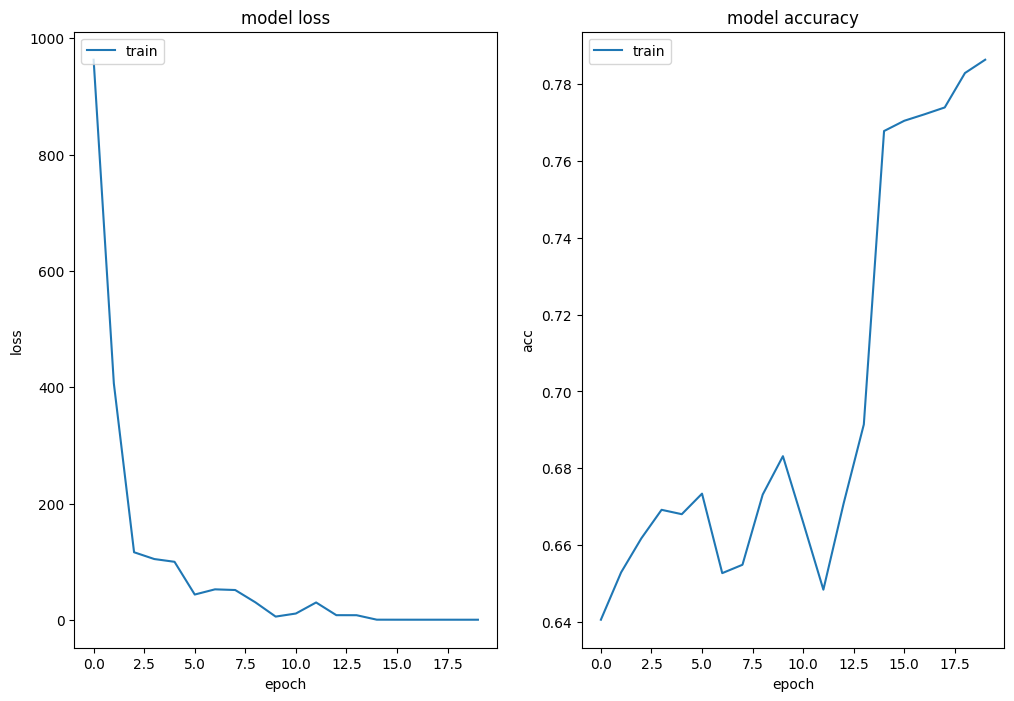

312/312 [==============================] - 1s 3ms/step - loss: 0.5252 - acc: 0.7879
Acuracy:  0.7879244685173035
Predicted     0    1   All
Actual                    
0          7396   80  7476
1          2031  447  2478
All        9427  527  9954


In [29]:
# Need to rerun seed for each DL cell
tf.random.set_seed(seed)

# Building the neural network
modeldl = Sequential()

modeldl.add(Dense(1000, input_dim=14, activation='relu'))
modeldl.add(Dense(100, activation='relu'))
modeldl.add(Dense(100, activation='relu'))
modeldl.add(Dense(50, activation='relu'))
modeldl.add(Dense(1, activation='sigmoid'))

# Compile model - do not change the loss function of metrics, you can change the optimiser if you wish!
modeldl.compile(loss='binary_crossentropy', optimizer="adam", metrics=['acc'])

# Fit the model, change verbose to 2 to see the training cycles.
# Feel free here to modify the batch size and epochs!
results = modeldl.fit(X_train, Y_train, epochs=20, batch_size=300, verbose=0)

plot_acc_loss(results)

# generate predictions from text data
dl_y_pred = (modeldl.predict(X_test) > 0.5).astype("int32")
dl_y_pred = dl_y_pred.flatten()

print("Acuracy: ", modeldl.evaluate(X_test,Y_test)[1])
print(pd.crosstab(Y_test, dl_y_pred, rownames=['Actual'], colnames=['Predicted'], margins=True))

##### Task: Target Group Bias

In [30]:
# Example for sex target groups  
female_pred = []      # Female was label encoded as 0
female_actual_class = []

male_pred = []        # Male was label encoded as 1
male_actual_class = []


# Populate the confusion matrix grouping by gender (col index 9) you could also do this via group by but would need to convert back to pandas dataframe.
# When grouping by multi class, you will have to modify the below code to include multi class, as for this example there is only two. 
# Also we are using the DT algorithm here, you can change this to DL if you selected that algorithm. 
for index,row in enumerate(X_test):
    if row[9] == 0:       # Female
        female_pred.append(dl_y_pred[index])
        female_actual_class.append(Y_test[index])
    elif row[9] == 1:     # Male
        male_pred.append(dl_y_pred[index])
        male_actual_class.append(Y_test[index])

# Confusion Matrix:
# overall TP, FP, TN, FN values, for binary values only
subMetrics("Female", female_actual_class, female_pred)
subMetrics("Male", male_actual_class, male_pred)

Metrics for:  Female
Total instances in the test set: 3244
Accuracy: 89.73 %
Predicted     0   1   All
Actual                   
0          2840  25  2865
1           308  71   379
All        3148  96  3244


Metrics for:  Male
Total instances in the test set: 6710
Accuracy: 73.5 %
Predicted     0    1   All
Actual                    
0          4556   55  4611
1          1723  376  2099
All        6279  431  6710




In [31]:
# Example for sex target groups  
white_pred = []      
white_actual_class = []
black_pred = []       
black_actual_class = []
asian_pred = []       
asian_actual_class = []
indian_pred = []       
indian_actual_class = []
other_pred = []       
other_actual_class = []

# Populate the confusion matrix grouping by gender (col index 9) you could also do this via group by but would need to convert back to pandas dataframe.
# When grouping by multi class, you will have to modify the below code to include multi class, as for this example there is only two. 
# Also we are using the DT algorithm here, you can change this to DL if you selected that algorithm. 
for index,row in enumerate(X_test):
    if row[8] == 4:       # Female
        white_pred.append(dl_y_pred[index])
        white_actual_class.append(Y_test[index])
    elif row[8] == 2:     # Male
        black_pred.append(dl_y_pred[index])
        black_actual_class.append(Y_test[index])
    elif row[8] == 1:     # Male
        asian_pred.append(dl_y_pred[index])
        asian_actual_class.append(Y_test[index])
    elif row[8] == 0:     # Male
        indian_pred.append(dl_y_pred[index])
        indian_actual_class.append(Y_test[index])
    elif row[8] == 3:     # Male
        other_pred.append(dl_y_pred[index])
        other_actual_class.append(Y_test[index])

# Confusion Matrix:
subMetrics("White", white_actual_class, white_pred)
subMetrics("Black", black_actual_class, black_pred)
subMetrics("Asian", asian_actual_class, asian_pred)
subMetrics("Indian", indian_actual_class, indian_pred)
subMetrics("Other", other_actual_class, other_pred)

Metrics for:  White
Total instances in the test set: 8604
Accuracy: 77.63 %
Predicted     0    1   All
Actual                    
0          6272   76  6348
1          1849  407  2256
All        8121  483  8604


Metrics for:  Black
Total instances in the test set: 885
Accuracy: 89.38 %
Predicted    0   1  All
Actual                 
0          773   1  774
1           93  18  111
All        866  19  885


Metrics for:  Asian
Total instances in the test set: 302
Accuracy: 74.83 %
Predicted    0   1  All
Actual                 
0          209   1  210
1           75  17   92
All        284  18  302


Metrics for:  Indian
Total instances in the test set: 88
Accuracy: 88.64 %
Predicted   0  1  All
Actual               
0          75  2   77
1           8  3   11
All        83  5   88


Metrics for:  Other
Total instances in the test set: 75
Accuracy: 92.0 %
Predicted   0  1  All
Actual               
0          67  0   67
1           6  2    8
All        73  2   75




#### Large

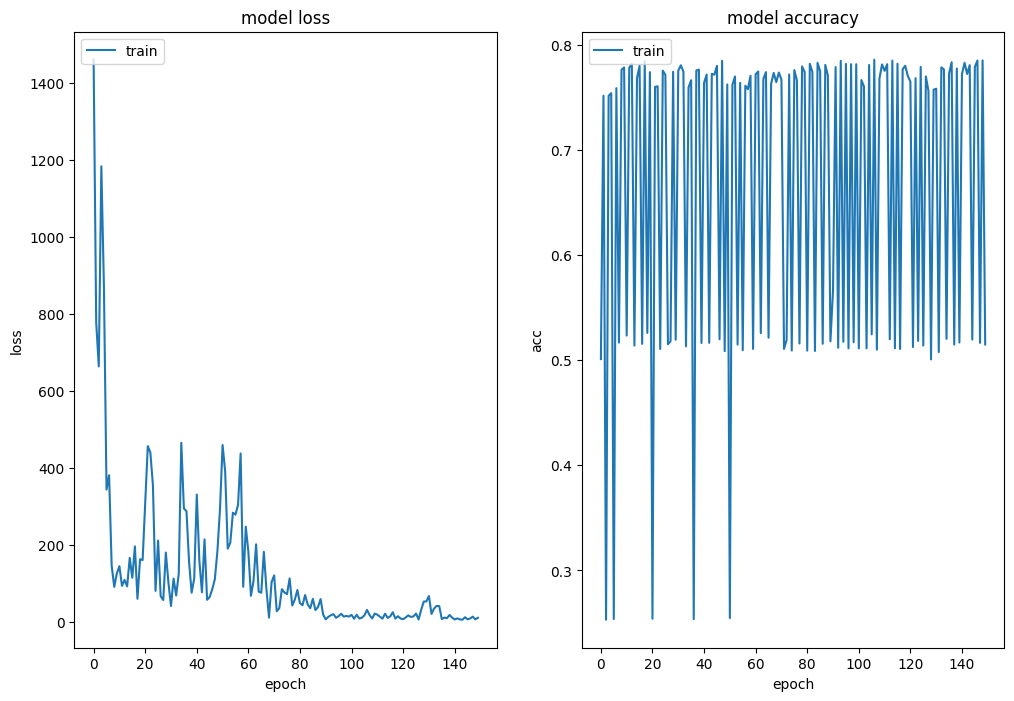

312/312 [==============================] - 1s 2ms/step - loss: 7.2460 - acc: 0.7856
Acuracy:  0.7856138348579407
Predicted     0    1   All
Actual                    
0          7419   57  7476
1          2077  401  2478
All        9496  458  9954


In [32]:
# Need to rerun seed for each DL cell
tf.random.set_seed(seed)

# Building the neural network
modeldl = Sequential()

modeldl.add(Dense(1000, input_dim=14, activation='relu'))
modeldl.add(Dense(100, activation='relu'))
modeldl.add(Dense(100, activation='relu'))
modeldl.add(Dense(50, activation='relu'))
modeldl.add(Dense(1, activation='sigmoid'))

# Compile model - do not change the loss function of metrics, you can change the optimiser if you wish!
modeldl.compile(loss='binary_crossentropy', optimizer="adam", metrics=['acc'])

# Fit the model, change verbose to 2 to see the training cycles.
# Feel free here to modify the batch size and epochs!
results = modeldl.fit(X_train, Y_train, epochs=150, batch_size=10000, verbose=0)

plot_acc_loss(results)

# generate predictions from text data
dl_y_pred = (modeldl.predict(X_test) > 0.5).astype("int32")
dl_y_pred = dl_y_pred.flatten()

print("Acuracy: ", modeldl.evaluate(X_test,Y_test)[1])
print(pd.crosstab(Y_test, dl_y_pred, rownames=['Actual'], colnames=['Predicted'], margins=True))

##### Task: Target Group Bias

In [ ]:
# Example for sex target groups  
female_pred = []      # Female was label encoded as 0
female_actual_class = []

male_pred = []        # Male was label encoded as 1
male_actual_class = []


# Populate the confusion matrix grouping by gender (col index 9) you could also do this via group by but would need to convert back to pandas dataframe.
# When grouping by multi class, you will have to modify the below code to include multi class, as for this example there is only two. 
# Also we are using the DT algorithm here, you can change this to DL if you selected that algorithm. 
for index,row in enumerate(X_test):
    if row[9] == 0:       # Female
        female_pred.append(dl_y_pred[index])
        female_actual_class.append(Y_test[index])
    elif row[9] == 1:     # Male
        male_pred.append(dl_y_pred[index])
        male_actual_class.append(Y_test[index])

# Confusion Matrix:
# overall TP, FP, TN, FN values, for binary values only
subMetrics("Female", female_actual_class, female_pred)
subMetrics("Male", male_actual_class, male_pred)

Metrics for:  Female
Total instances in the test set: 3244
Accuracy: 89.43 %
Predicted     0    1   All
Actual                    
0          2830   35  2865
1           308   71   379
All        3138  106  3244


Metrics for:  Male
Total instances in the test set: 6710
Accuracy: 73.65 %
Predicted     0    1   All
Actual                    
0          4543   68  4611
1          1700  399  2099
All        6243  467  6710




In [ ]:
# Example for sex target groups  
white_pred = []      
white_actual_class = []
black_pred = []       
black_actual_class = []
asian_pred = []       
asian_actual_class = []
indian_pred = []       
indian_actual_class = []
other_pred = []       
other_actual_class = []

# Populate the confusion matrix grouping by gender (col index 9) you could also do this via group by but would need to convert back to pandas dataframe.
# When grouping by multi class, you will have to modify the below code to include multi class, as for this example there is only two. 
# Also we are using the DT algorithm here, you can change this to DL if you selected that algorithm. 
for index,row in enumerate(X_test):
    if row[8] == 4:       # Female
        white_pred.append(dl_y_pred[index])
        white_actual_class.append(Y_test[index])
    elif row[8] == 2:     # Male
        black_pred.append(dl_y_pred[index])
        black_actual_class.append(Y_test[index])
    elif row[8] == 1:     # Male
        asian_pred.append(dl_y_pred[index])
        asian_actual_class.append(Y_test[index])
    elif row[8] == 0:     # Male
        indian_pred.append(dl_y_pred[index])
        indian_actual_class.append(Y_test[index])
    elif row[8] == 3:     # Male
        other_pred.append(dl_y_pred[index])
        other_actual_class.append(Y_test[index])

# Confusion Matrix:
subMetrics("White", white_actual_class, white_pred)
subMetrics("Black", black_actual_class, black_pred)
subMetrics("Asian", asian_actual_class, asian_pred)
subMetrics("Indian", indian_actual_class, indian_pred)
subMetrics("Other", other_actual_class, other_pred)

Metrics for:  White
Total instances in the test set: 8604
Accuracy: 77.63 %
Predicted     0    1   All
Actual                    
0          6254   94  6348
1          1831  425  2256
All        8085  519  8604


Metrics for:  Black
Total instances in the test set: 885
Accuracy: 89.38 %
Predicted    0   1  All
Actual                 
0          769   5  774
1           89  22  111
All        858  27  885


Metrics for:  Asian
Total instances in the test set: 302
Accuracy: 75.17 %
Predicted    0   1  All
Actual                 
0          209   1  210
1           74  18   92
All        283  19  302


Metrics for:  Indian
Total instances in the test set: 88
Accuracy: 88.64 %
Predicted   0  1  All
Actual               
0          75  2   77
1           8  3   11
All        83  5   88


Metrics for:  Other
Total instances in the test set: 75
Accuracy: 90.67 %
Predicted   0  1  All
Actual               
0          66  1   67
1           6  2    8
All        72  3   75




#### Small
- further testing


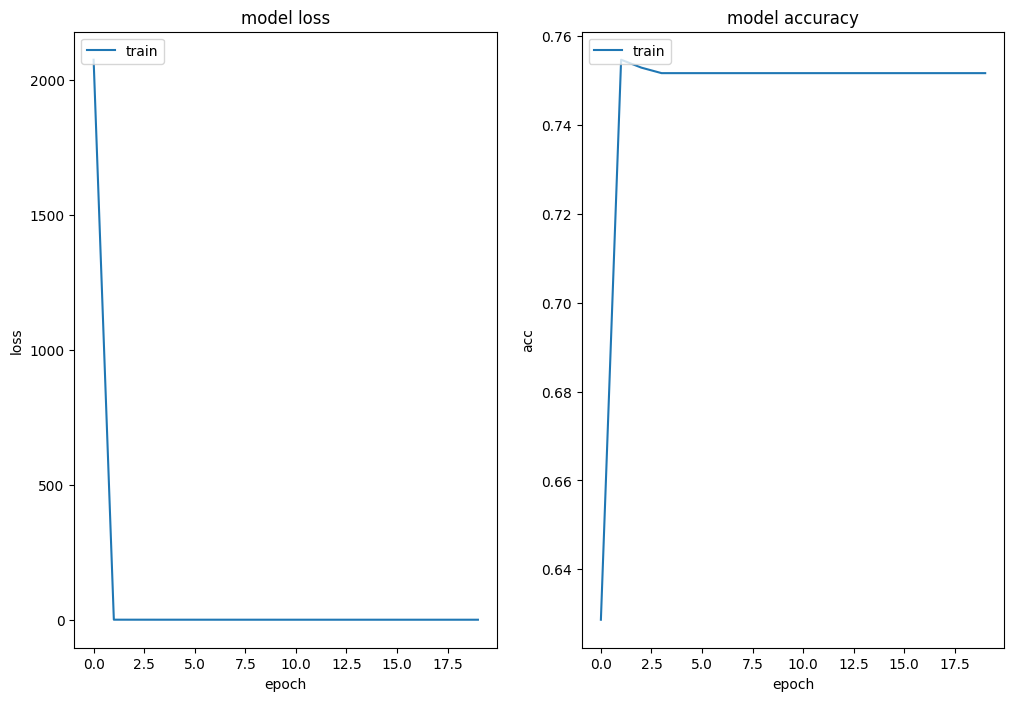

312/312 [==============================] - 1s 2ms/step - loss: 0.5680 - acc: 0.7517
Acuracy:  0.7516576051712036
Predicted     0  1   All
Actual                  
0          7476  0  7476
1          2472  6  2478
All        9948  6  9954


In [36]:
# Need to rerun seed for each DL cell
tf.random.set_seed(seed)

# Building the neural network
modeldl = Sequential()

modeldl.add(Dense(100, input_dim=14, activation='relu'))
modeldl.add(Dense(10, activation='relu'))
modeldl.add(Dense(10, activation='relu'))
modeldl.add(Dense(5, activation='relu'))
modeldl.add(Dense(1, activation='sigmoid'))

# Compile model - do not change the loss function of metrics, you can change the optimiser if you wish!
modeldl.compile(loss='binary_crossentropy', optimizer="adam", metrics=['acc'])

# Fit the model, change verbose to 2 to see the training cycles.
# Feel free here to modify the batch size and epochs!
results = modeldl.fit(X_train, Y_train, epochs=20, batch_size=300, verbose=0)

plot_acc_loss(results)

# generate predictions from text data
dl_y_pred = (modeldl.predict(X_test) > 0.5).astype("int32")
dl_y_pred = dl_y_pred.flatten()

print("Acuracy: ", modeldl.evaluate(X_test,Y_test)[1])
print(pd.crosstab(Y_test, dl_y_pred, rownames=['Actual'], colnames=['Predicted'], margins=True))

##### Task: Target Group Bias

In [37]:
# Example for sex target groups  
female_pred = []      # Female was label encoded as 0
female_actual_class = []

male_pred = []        # Male was label encoded as 1
male_actual_class = []


# Populate the confusion matrix grouping by gender (col index 9) you could also do this via group by but would need to convert back to pandas dataframe.
# When grouping by multi class, you will have to modify the below code to include multi class, as for this example there is only two. 
# Also we are using the DT algorithm here, you can change this to DL if you selected that algorithm. 
for index,row in enumerate(X_test):
    if row[9] == 0:       # Female
        female_pred.append(dl_y_pred[index])
        female_actual_class.append(Y_test[index])
    elif row[9] == 1:     # Male
        male_pred.append(dl_y_pred[index])
        male_actual_class.append(Y_test[index])

# Confusion Matrix:
# overall TP, FP, TN, FN values, for binary values only
subMetrics("Female", female_actual_class, female_pred)
subMetrics("Male", male_actual_class, male_pred)

Metrics for:  Female
Total instances in the test set: 3244
Accuracy: 88.32 %
Predicted     0   All
Actual               
0          2865  2865
1           379   379
All        3244  3244


Metrics for:  Male
Total instances in the test set: 6710
Accuracy: 68.81 %
Predicted     0  1   All
Actual                  
0          4611  0  4611
1          2093  6  2099
All        6704  6  6710




In [38]:
# Example for sex target groups  
white_pred = []      
white_actual_class = []
black_pred = []       
black_actual_class = []
asian_pred = []       
asian_actual_class = []
indian_pred = []       
indian_actual_class = []
other_pred = []       
other_actual_class = []

# Populate the confusion matrix grouping by gender (col index 9) you could also do this via group by but would need to convert back to pandas dataframe.
# When grouping by multi class, you will have to modify the below code to include multi class, as for this example there is only two. 
# Also we are using the DT algorithm here, you can change this to DL if you selected that algorithm. 
for index,row in enumerate(X_test):
    if row[8] == 4:       # Female
        white_pred.append(dl_y_pred[index])
        white_actual_class.append(Y_test[index])
    elif row[8] == 2:     # Male
        black_pred.append(dl_y_pred[index])
        black_actual_class.append(Y_test[index])
    elif row[8] == 1:     # Male
        asian_pred.append(dl_y_pred[index])
        asian_actual_class.append(Y_test[index])
    elif row[8] == 0:     # Male
        indian_pred.append(dl_y_pred[index])
        indian_actual_class.append(Y_test[index])
    elif row[8] == 3:     # Male
        other_pred.append(dl_y_pred[index])
        other_actual_class.append(Y_test[index])

# Confusion Matrix:
subMetrics("White", white_actual_class, white_pred)
subMetrics("Black", black_actual_class, black_pred)
subMetrics("Asian", asian_actual_class, asian_pred)
subMetrics("Indian", indian_actual_class, indian_pred)
subMetrics("Other", other_actual_class, other_pred)

Metrics for:  White
Total instances in the test set: 8604
Accuracy: 73.85 %
Predicted     0  1   All
Actual                  
0          6348  0  6348
1          2250  6  2256
All        8598  6  8604


Metrics for:  Black
Total instances in the test set: 885
Accuracy: 87.46 %
Predicted    0  All
Actual             
0          774  774
1          111  111
All        885  885


Metrics for:  Asian
Total instances in the test set: 302
Accuracy: 69.54 %
Predicted    0  All
Actual             
0          210  210
1           92   92
All        302  302


Metrics for:  Indian
Total instances in the test set: 88
Accuracy: 87.5 %
Predicted   0  All
Actual            
0          77   77
1          11   11
All        88   88


Metrics for:  Other
Total instances in the test set: 75
Accuracy: 89.33 %
Predicted   0  All
Actual            
0          67   67
1           8    8
All        75   75


